# Butterfly Recognition

The datset for this notebook is taken from - [here](https://www.kaggle.com/gpiosenka/butterfly-images40-species). <br>

Train, Test. Validation data set for 50 butterfly species. All images are 224 X 224 X 3 in jpg format .
Train set consists of 4955 images partitioned into 50 sub directories one for each species.
Test set consists of 250 images partitioned into 50 sub directories with 5 test images per species.
Valid set consists of 250 images partitioned into 50 sub directories with 5 validation images per species.
1 CSV file is included with 3 columns filepaths, labels and dataset. filepaths is the relative path to an image.
labels is the string name of the species associate with the image file.
dataset species the directory (train, test, valid) that contains the image file.

The model classifies for the given classes - 'adonis','american snoot','an 88','banded peacock','beckers white','black hairstreak', 'cabbage white','chestnut','clodius parnassian','clouded sulphur','copper tail','crecent','crimson patch','eastern coma','gold banded', 'great eggfly','grey hairstreak','indra swallow','julia','large marble','malachite','mangrove skipper','metalmark','monarch','morning cloak', 'orange oakleaf','orange tip','orchard swallow','painted lady','paper kite','peacock','pine white','pipevine swallow','purple hairstreak','question mark', 'red admiral','red spotted purple','scarce swallow','silver spot skipper','sixspot burnet','skipper','sootywing','southern dogface','straited queen', 'two barred flasher','ulyses','viceroy','wood satyr','yellow swallow tail','zebra long wing'.

![Img](https://raw.githubusercontent.com/Hrushi11/Butterfly_Recognition/main/images/straited%20queen.png)

## Getting our data using Kaggle API

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gpiosenka/butterfly-images40-species

 99% 835M/842M [00:07<00:00, 122MB/s] 
100% 842M/842M [00:07<00:00, 118MB/s]


In [ ]:
# To view which GPU are we running 
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4fea7eb5-210a-fca4-101e-ed85517559cf)


In [ ]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2021-08-02 16:57:39--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2021-08-02 16:57:39 (82.5 MB/s) - ‘helper_functions.py’ saved [10139/10139]



## Importing Dependancies

In [ ]:
# Importing dependancies
import os
import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves, make_confusion_matrix, compare_historys

In [ ]:
# Unzipping our data
unzip_data("/content/butterfly-images40-species.zip")

In [ ]:
# deleting the zip file
!rm butterfly-images40-species.zip

In [ ]:
# deleting the extra folder
!rm -rf butterflies_rev2

In [ ]:
# A look through all the directories in the dataset
walk_through_dir("/content/butterflies")

There are 3 directories and 1 images in '/content/butterflies'.
There are 50 directories and 0 images in '/content/butterflies/valid'.
There are 0 directories and 5 images in '/content/butterflies/valid/straited queen'.
There are 0 directories and 5 images in '/content/butterflies/valid/paper kite'.
There are 0 directories and 5 images in '/content/butterflies/valid/beckers white'.
There are 0 directories and 5 images in '/content/butterflies/valid/sootywing'.
There are 0 directories and 5 images in '/content/butterflies/valid/clouded sulphur'.
There are 0 directories and 5 images in '/content/butterflies/valid/monarch'.
There are 0 directories and 5 images in '/content/butterflies/valid/two barred flasher'.
There are 0 directories and 5 images in '/content/butterflies/valid/indra swallow'.
There are 0 directories and 5 images in '/content/butterflies/valid/copper tail'.
There are 0 directories and 5 images in '/content/butterflies/valid/wood satyr'.
There are 0 directories and 5 image

In [ ]:
labels = os.listdir("/content/butterflies/train")
len(labels)

50

## Getting our data ready

In [ ]:
# creating a list of all the training file paths
train_file_paths = []
for elem in labels:
  dir_path = "/content/butterflies/train/" + elem
  paths = os.listdir(dir_path)
  for path in paths:
    path = dir_path + "/" + path
    train_file_paths.append(path)

In [ ]:
len(train_file_paths)

4955

In [ ]:
# randomly checking a part of the list
train_file_paths[100:110]

['/content/butterflies/train/paper kite/67.jpg',
 '/content/butterflies/train/paper kite/43.jpg',
 '/content/butterflies/train/paper kite/10.jpg',
 '/content/butterflies/train/paper kite/24.jpg',
 '/content/butterflies/train/paper kite/03.jpg',
 '/content/butterflies/train/paper kite/27.jpg',
 '/content/butterflies/train/paper kite/28.jpg',
 '/content/butterflies/train/paper kite/57.jpg',
 '/content/butterflies/train/paper kite/23.jpg',
 '/content/butterflies/train/paper kite/55.jpg']

In [ ]:
# To read and preprocess the image
def load_and_preprocess(filepath):
  """
  Takes a file path and preprocess images into 224 x 3 
  """
  img_file = tf.io.read_file(filepath)
  img = tf.image.decode_image(img_file)
  img = tf.image.resize(img, (224, 224))
  
  return img

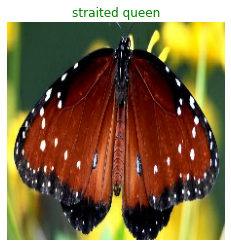

In [ ]:
# Visualizing random image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)
plt.axis(False)
plt.title(random_file.split("/")[4], color="green")
plt.imshow(img / 255.);

### Visualizing multiple random images

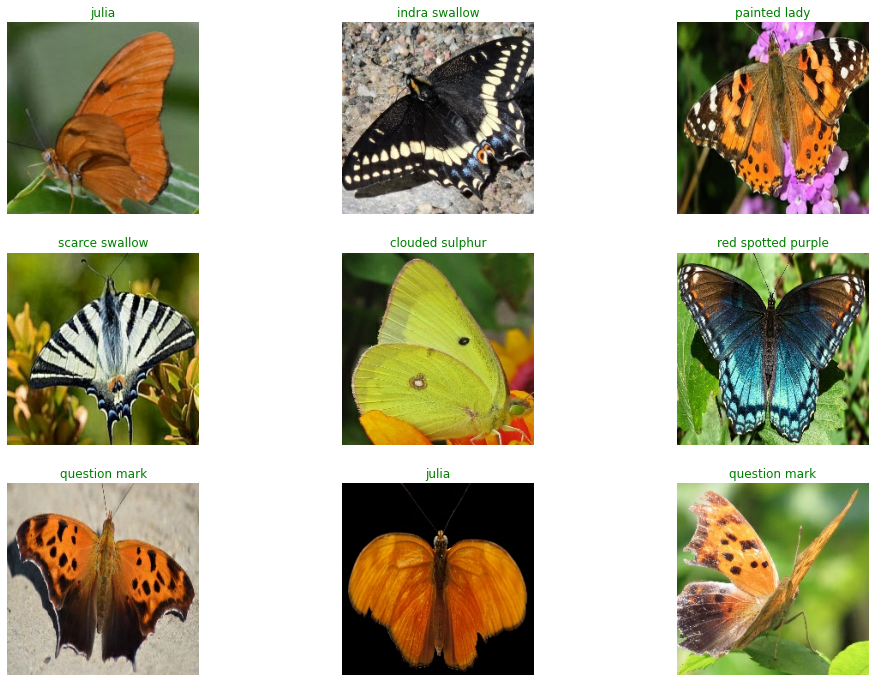

In [ ]:
# Visualizing multiple random images
plt.figure(figsize=(17, 12))
for i in range(9):
  # Random selecting an image from the train dataset
  random_file = random.choice(train_file_paths)
  img = load_and_preprocess(random_file)

  # Plotting the random images
  plt.subplot(3, 3, i+1)
  plt.title(random_file.split("/")[4], color="green")
  plt.axis(False)
  plt.imshow(img / 255.)

## Data Augmentation layer

In [ ]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

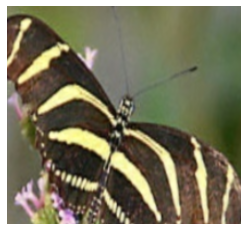

In [ ]:
# Visualizing the augmented image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)

aug_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.axis(False)
plt.imshow(aug_img[0] / 255.)

### Visualizing a single augmented image

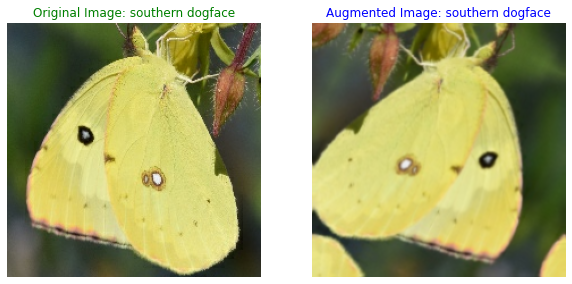

In [ ]:
# Visualizing the augmentated image with the original image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)
aug_img = data_augmentation(tf.expand_dims(img, axis=0))
aug_img = tf.image.resize(aug_img[0], (224, 224))
label = random_file.split("/")[4]

plt.figure(figsize=(10, 7))
# Plot for original image
plt.subplot(1, 2, 1)
plt.title(f"Original Image: {label}", color = "green")
plt.axis(False)
plt.imshow(img / 255.)

# Plot for augmented image
plt.subplot(1, 2, 2)
plt.title(f"Augmented Image: {label}", color = "blue")
plt.axis(False)
plt.imshow(aug_img / 255.);

### Visualizing multiple augmented images

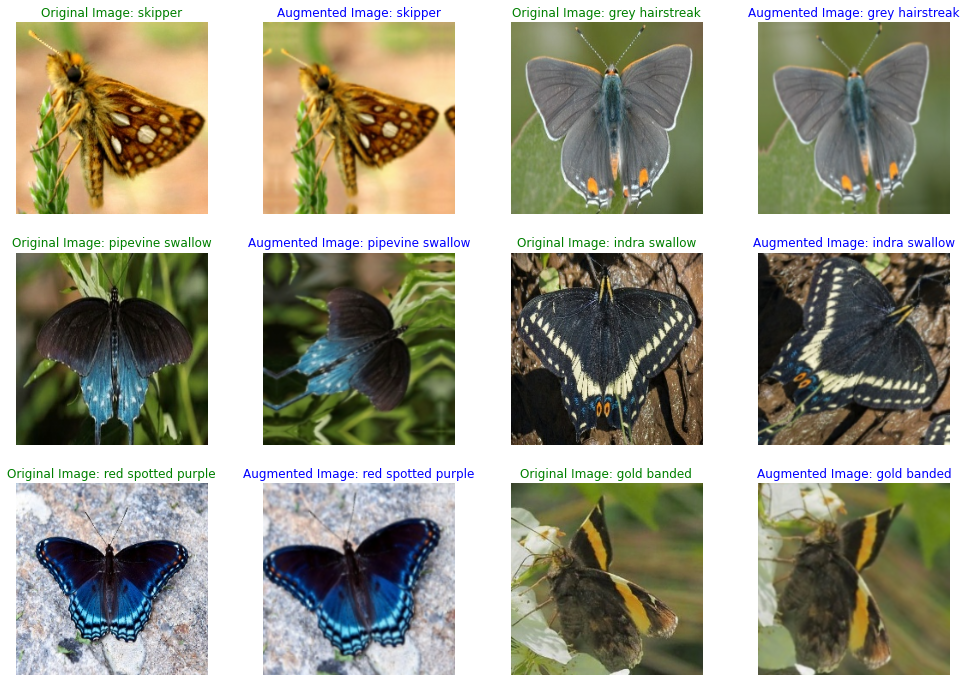

In [ ]:
# Visualizing multiple augmentated images with original images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  # generating random file path & aug img
  random_file = random.choice(train_file_paths)
  img = load_and_preprocess(random_file)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], (224, 224))
  label = random_file.split("/")[4]
  
  # plotting the original image
  plt.subplot(3, 4, i)
  plt.title(f"Original Image: {label}", color = "green")
  plt.axis(False)
  plt.imshow(img / 255.)
  
  # plotting the augmented image
  plt.subplot(3, 4, i+1)
  plt.title(f"Augmented Image: {label}", color = "blue")
  plt.axis(False)
  plt.imshow(aug_img / 255.);

## Data Generators

In [ ]:
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

In [ ]:
train_data = train_data_gen.flow_from_directory("/content/butterflies/train",
                                                target_size=(224, 224),
                                                seed=42)

valid_data = valid_data_gen.flow_from_directory("/content/butterflies/valid",
                                                target_size=(224, 224),
                                                shuffle=False)

test_data = test_data_gen.flow_from_directory("/content/butterflies/test",
                                                target_size=(224, 224),
                                                shuffle=False)

Found 4955 images belonging to 50 classes.
Found 250 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


In [ ]:
# To get all the class names
class_ = train_data.class_indices
class_names = []
for key in class_.keys():
  class_names.append(key)

In [ ]:
class_names

['adonis',
 'american snoot',
 'an 88',
 'banded peacock',
 'beckers white',
 'black hairstreak',
 'cabbage white',
 'chestnut',
 'clodius parnassian',
 'clouded sulphur',
 'copper tail',
 'crecent',
 'crimson patch',
 'eastern coma',
 'gold banded',
 'great eggfly',
 'grey hairstreak',
 'indra swallow',
 'julia',
 'large marble',
 'malachite',
 'mangrove skipper',
 'metalmark',
 'monarch',
 'morning cloak',
 'orange oakleaf',
 'orange tip',
 'orchard swallow',
 'painted lady',
 'paper kite',
 'peacock',
 'pine white',
 'pipevine swallow',
 'purple hairstreak',
 'question mark',
 'red admiral',
 'red spotted purple',
 'scarce swallow',
 'silver spot skipper',
 'sixspot burnet',
 'skipper',
 'sootywing',
 'southern dogface',
 'straited queen',
 'two barred flasher',
 'ulyses',
 'viceroy',
 'wood satyr',
 'yellow swallow tail',
 'zebra long wing']

## Training our Models


### Model 1

In [ ]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting input layer 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) 
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
155/155 [==============================] - 76s 447ms/step - loss: 2.0292 - accuracy: 0.6125 - val_loss: 1.2592 - val_accuracy: 0.8040
Epoch 2/5
155/155 [==============================] - 53s 344ms/step - loss: 0.7720 - accuracy: 0.8692 - val_loss: 0.7581 - val_accuracy: 0.8960
Epoch 3/5
155/155 [==============================] - 52s 335ms/step - loss: 0.5180 - accuracy: 0.9049 - val_loss: 0.5798 - val_accuracy: 0.9000
Epoch 4/5
155/155 [==============================] - 44s 285ms/step - loss: 0.4050 - accuracy: 0.9255 - val_loss: 0.4514 - val_accuracy: 0.9480
Epoch 5/5
155/155 [==============================] - 43s 275ms/step - loss: 0.3350 - accuracy: 0.9338 - val_loss: 0.4040 - val_accuracy: 0.9400


In [ ]:
model_1.evaluate(test_data)

8/8 [==============================] - 1s 128ms/step - loss: 0.4121 - accuracy: 0.9240


[0.41212189197540283, 0.9240000247955322]

### Loss curves for original model

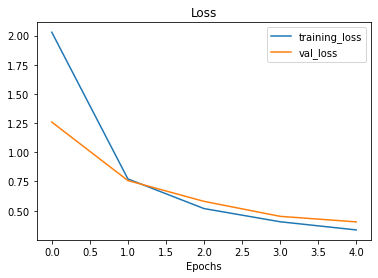

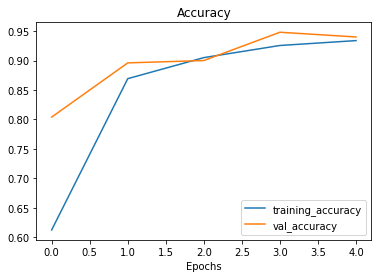

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.save("/content/drive/MyDrive/Butterfly-Recognition/Model_1")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Butterfly-Recognition/Model_1/assets


## Fine tuning the model 

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 

history_1_fine_tune_1 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=valid_data,
                                    validation_steps= len(valid_data), 
                                    initial_epoch=history_1.epoch[-1])

Epoch 5/10
155/155 [==============================] - 53s 291ms/step - loss: 0.2435 - accuracy: 0.9413 - val_loss: 0.2148 - val_accuracy: 0.9360
Epoch 6/10
155/155 [==============================] - 39s 249ms/step - loss: 0.1956 - accuracy: 0.9457 - val_loss: 0.1746 - val_accuracy: 0.9760
Epoch 7/10
155/155 [==============================] - 41s 263ms/step - loss: 0.1662 - accuracy: 0.9528 - val_loss: 0.1651 - val_accuracy: 0.9680
Epoch 8/10
155/155 [==============================] - 38s 247ms/step - loss: 0.1537 - accuracy: 0.9590 - val_loss: 0.1452 - val_accuracy: 0.9640
Epoch 9/10
155/155 [==============================] - 38s 242ms/step - loss: 0.1428 - accuracy: 0.9586 - val_loss: 0.1606 - val_accuracy: 0.9560
Epoch 10/10
155/155 [==============================] - 35s 229ms/step - loss: 0.1195 - accuracy: 0.9663 - val_loss: 0.1309 - val_accuracy: 0.9720


In [ ]:
model_1.evaluate(test_data)

8/8 [==============================] - 1s 128ms/step - loss: 0.1758 - accuracy: 0.9680


[0.17583806812763214, 0.9679999947547913]

### Compared historys with the original model

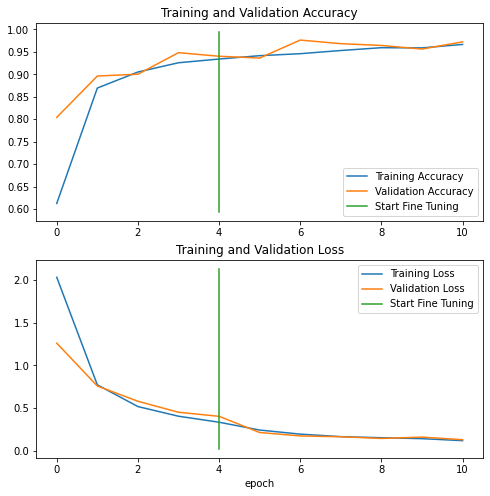

In [ ]:
compare_historys(history_1, history_1_fine_tune_1)

In [ ]:
model_1.save("/content/drive/MyDrive/Butterfly-Recognition/Model_2")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Butterfly-Recognition/Model_2/assets


## Insights into the best model

In [ ]:
label_val = []
for elem in test_data.filepaths:
  for cl in range(50):
    if elem.split("/")[4] == class_names[cl]:
      label_val.append(cl)

In [ ]:
label_val[5:10]

[1, 1, 1, 1, 1]

In [ ]:
# Getting prediction probabilites
pred_prob = model_1.predict(test_data)
pred_prob

array([[8.1247598e-01, 1.9608064e-05, 8.4864783e-05, ..., 3.2571238e-04,
        1.7534398e-05, 9.8661276e-06],
       [5.8847833e-01, 2.0846370e-05, 2.4964868e-06, ..., 2.0753338e-05,
        2.3687000e-05, 6.9808941e-08],
       [9.7818691e-01, 1.7820315e-06, 3.9221965e-07, ..., 5.4445458e-08,
        1.9965878e-04, 9.5505243e-07],
       ...,
       [2.0196762e-06, 1.0442600e-04, 1.8454040e-05, ..., 1.2071504e-07,
        8.4692489e-05, 9.8753589e-01],
       [2.8213247e-09, 1.4057372e-07, 3.0933300e-08, ..., 2.7334593e-08,
        3.7891237e-04, 9.9538982e-01],
       [1.5570292e-08, 4.8477432e-06, 2.1701456e-07, ..., 1.0687562e-09,
        2.0701880e-06, 9.9944359e-01]], dtype=float32)

In [ ]:
y_pred = pred_prob.argmax(axis=1)
y_pred[:50]

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4, 19,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7, 31,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9])

In [ ]:
y_true = np.array(label_val)
y_true[:50]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9])

### Confusion Matrix

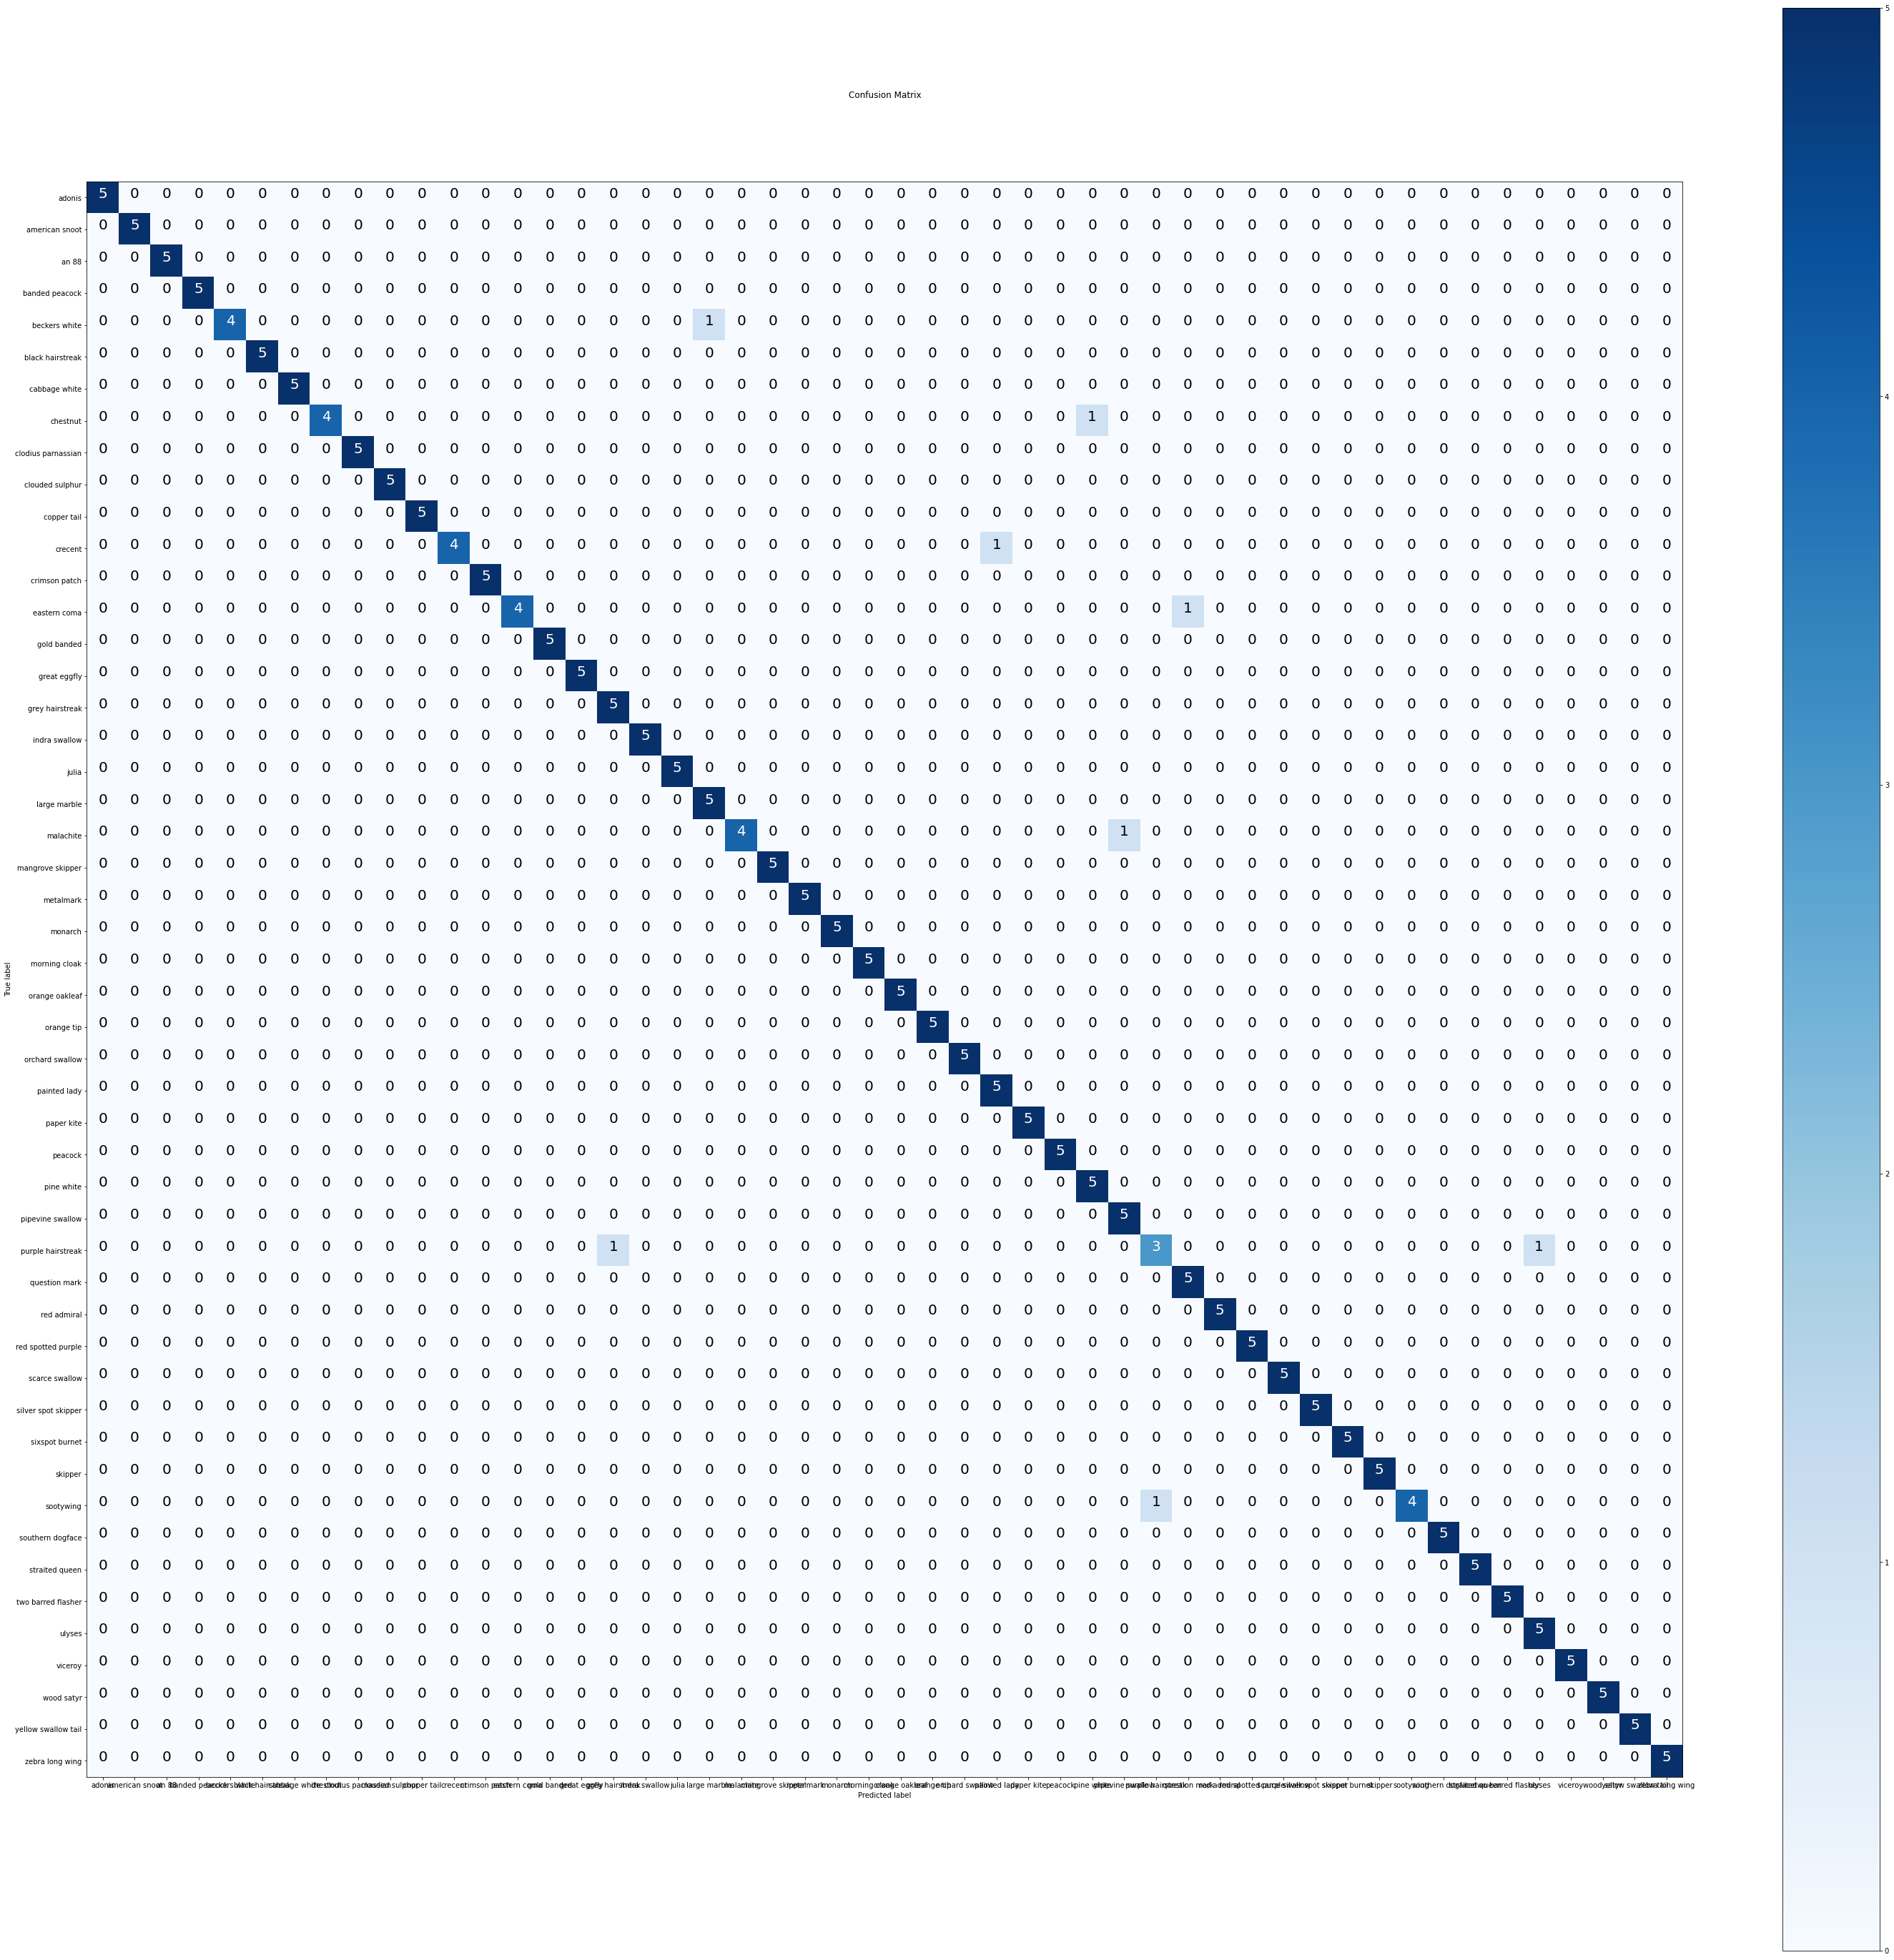

In [ ]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=20,
                      norm=False)

### Classification Report

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
          17       1.00    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true, y_pred, output_dict=True)
classification_report_dict

{'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '10': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '11': {'f1-score': 0.888888888888889,
  'precision': 1.0,
  'recall': 0.8,
  'support': 5},
 '12': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '13': {'f1-score': 0.888888888888889,
  'precision': 1.0,
  'recall': 0.8,
  'support': 5},
 '14': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '15': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '16': {'f1-score': 0.9090909090909091,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'support': 5},
 '17': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '18': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 5},
 '19': {'f1-score': 0.9090909090909091,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'support': 5},
 '2': {'f1-sco

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'adonis': 1.0,
 'american snoot': 1.0,
 'an 88': 1.0,
 'banded peacock': 1.0,
 'beckers white': 0.888888888888889,
 'black hairstreak': 1.0,
 'cabbage white': 1.0,
 'chestnut': 0.888888888888889,
 'clodius parnassian': 1.0,
 'clouded sulphur': 1.0,
 'copper tail': 1.0,
 'crecent': 0.888888888888889,
 'crimson patch': 1.0,
 'eastern coma': 0.888888888888889,
 'gold banded': 1.0,
 'great eggfly': 1.0,
 'grey hairstreak': 0.9090909090909091,
 'indra swallow': 1.0,
 'julia': 1.0,
 'large marble': 0.9090909090909091,
 'malachite': 0.888888888888889,
 'mangrove skipper': 1.0,
 'metalmark': 1.0,
 'monarch': 1.0,
 'morning cloak': 1.0,
 'orange oakleaf': 1.0,
 'orange tip': 1.0,
 'orchard swallow': 1.0,
 'painted lady': 0.9090909090909091,
 'paper kite': 1.0,
 'peacock': 1.0,
 'pine white': 0.9090909090909091,
 'pipevine swallow': 0.9090909090909091,
 'purple hairstreak': 0.6666666666666665,
 'question mark': 0.9090909090909091,
 'red admiral': 1.0,
 'red spotted purple': 1.0,
 'scarce swallo

In [ ]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
0                adonis  1.000000
37       scarce swallow  1.000000
24        morning cloak  1.000000
1        american snoot  1.000000
26           orange tip  1.000000
27      orchard swallow  1.000000
29           paper kite  1.000000
30              peacock  1.000000
35          red admiral  1.000000
36   red spotted purple  1.000000
38  silver spot skipper  1.000000
22            metalmark  1.000000
39       sixspot burnet  1.000000
40              skipper  1.000000
42     southern dogface  1.000000
43       straited queen  1.000000
44   two barred flasher  1.000000
46              viceroy  1.000000
47           wood satyr  1.000000
48  yellow swallow tail  1.000000
23              monarch  1.000000
25       orange oakleaf  1.000000
21     mangrove skipper  1.000000
10          copper tail  1.000000
2                 an 88  1.000000
3        banded peacock  1.000000
5      black hairstreak  1.000000
6         cabbage white  1.000000
8    clodius parnassian  1.000000
9       clouded sulphur  1.000000
12        crimson patch  1.000000
49      zebra long wing  1.000000
18                julia  1.000000
17        indra swallow  1.000000
14          gold banded  1.000000
15         great eggfly  1.000000
32     pipevine swallow  0.909091
19         large marble  0.909091
45               ulyses  0.909091
16      grey hairstreak  0.909091
31           pine white  0.909091
34        question mark  0.909091
28         painted lady  0.909091
41            sootywing  0.888889
7              chestnut  0.888889
11              crecent  0.888889
20            malachite  0.888889
13         eastern coma  0.888889
4         beckers white  0.888889
33    purple hairstreak  0.666667

### Plotting F1 scores

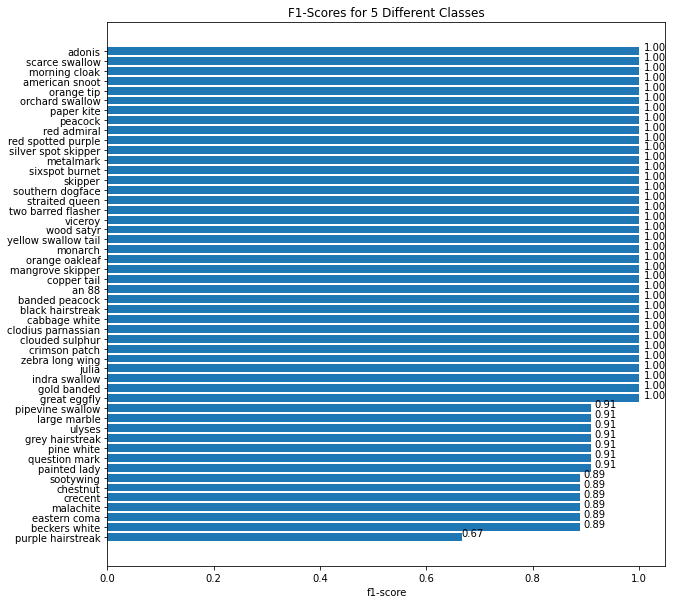

In [ ]:
# plotting F1 scores
fig, ax = plt.subplots(figsize=(10, 10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 5 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Predictions on the model

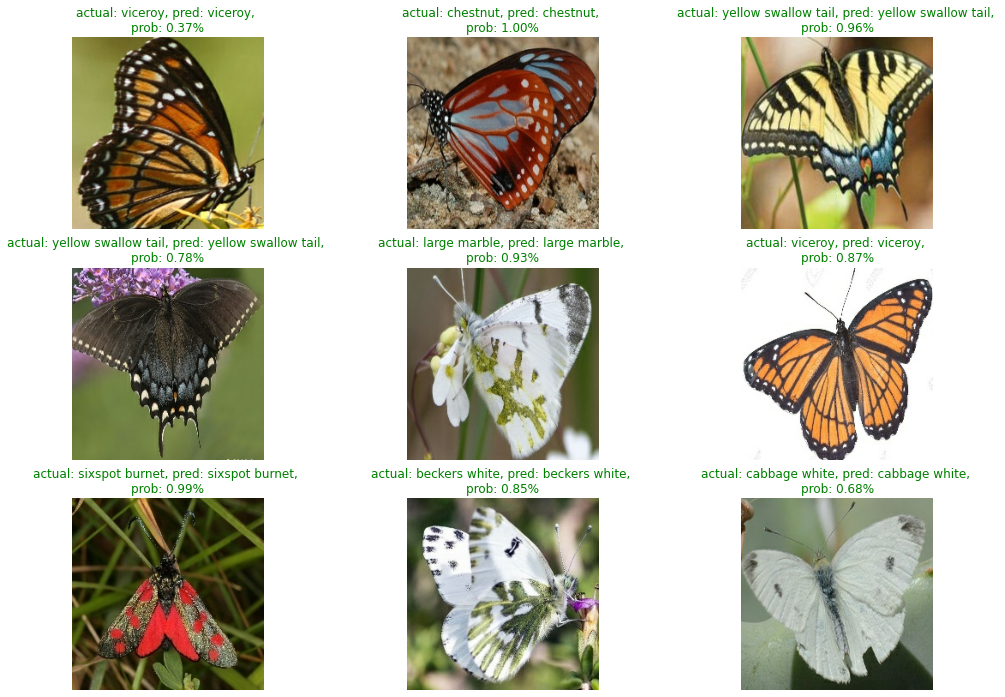

In [ ]:
plt.figure(figsize=(17, 12))
for i in range(9):
  # Choose a random image from a random class 
  filepath = random.choice(test_paths)
  class_name = filepath.split("/")[4]

  # Load the image and make predictions
  img = load_and_preprocess(filepath) 
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, \nprob: {pred_prob.max():.2f}%", c=title_color)
  plt.axis(False);

In [ ]:
df_pred = pd.DataFrame({"filename" : test_paths,
                         "label": test_labels,
                         "label_val": label_val,
                         "pred": y_pred})

In [ ]:
df_pred.head()

filename   label  label_val  pred
0  /content/butterflies/test/adonis/1.jpg  adonis          0     0
1  /content/butterflies/test/adonis/2.jpg  adonis          0     0
2  /content/butterflies/test/adonis/3.jpg  adonis          0     0
3  /content/butterflies/test/adonis/4.jpg  adonis          0     0
4  /content/butterflies/test/adonis/5.jpg  adonis          0     0

In [ ]:
pred_probs = model_1.predict(test_data)
pred_probs

array([[8.1247598e-01, 1.9608064e-05, 8.4864783e-05, ..., 3.2571238e-04,
        1.7534398e-05, 9.8661276e-06],
       [5.8847833e-01, 2.0846370e-05, 2.4964868e-06, ..., 2.0753338e-05,
        2.3687000e-05, 6.9808941e-08],
       [9.7818691e-01, 1.7820315e-06, 3.9221965e-07, ..., 5.4445458e-08,
        1.9965878e-04, 9.5505243e-07],
       ...,
       [2.0196762e-06, 1.0442600e-04, 1.8454040e-05, ..., 1.2071504e-07,
        8.4692489e-05, 9.8753589e-01],
       [2.8213247e-09, 1.4057372e-07, 3.0933300e-08, ..., 2.7334593e-08,
        3.7891237e-04, 9.9538982e-01],
       [1.5570292e-08, 4.8477432e-06, 2.1701456e-07, ..., 1.0687562e-09,
        2.0701880e-06, 9.9944359e-01]], dtype=float32)

In [ ]:
pred_df = pd.DataFrame({"img_path": test_paths,
                        "y_true": y_true,
                        "y_pred": y_pred,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_true],
                        "y_pred_classname": [class_names[i] for i in y_pred]}) 
pred_df.head()

img_path  ...  y_pred_classname
0  /content/butterflies/test/adonis/1.jpg  ...            adonis
1  /content/butterflies/test/adonis/2.jpg  ...            adonis
2  /content/butterflies/test/adonis/3.jpg  ...            adonis
3  /content/butterflies/test/adonis/4.jpg  ...            adonis
4  /content/butterflies/test/adonis/5.jpg  ...            adonis

[5 rows x 6 columns]

In [ ]:
# check for pred 
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  /content/butterflies/test/adonis/1.jpg  ...          True
1  /content/butterflies/test/adonis/2.jpg  ...          True
2  /content/butterflies/test/adonis/3.jpg  ...          True
3  /content/butterflies/test/adonis/4.jpg  ...          True
4  /content/butterflies/test/adonis/5.jpg  ...          True

[5 rows x 7 columns]

In [ ]:
# Get the top wrong examples
top_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:10]
top_wrong.head(20)

img_path  ...  pred_correct
55             /content/butterflies/test/crecent/1.jpg  ...         False
169  /content/butterflies/test/purple hairstreak/5.jpg  ...         False
21       /content/butterflies/test/beckers white/2.jpg  ...         False
100          /content/butterflies/test/malachite/1.jpg  ...         False
168  /content/butterflies/test/purple hairstreak/4.jpg  ...         False
207          /content/butterflies/test/sootywing/3.jpg  ...         False
69        /content/butterflies/test/eastern coma/5.jpg  ...         False
38            /content/butterflies/test/chestnut/4.jpg  ...         False

[8 rows x 7 columns]

In [ ]:
filepaths = np.array(top_wrong["img_path"])
true = np.array(top_wrong["y_true_classname"])
pred = np.array(top_wrong["y_pred_classname"])
prob = np.array(top_wrong["pred_conf"])

## Wrongly predicted classes

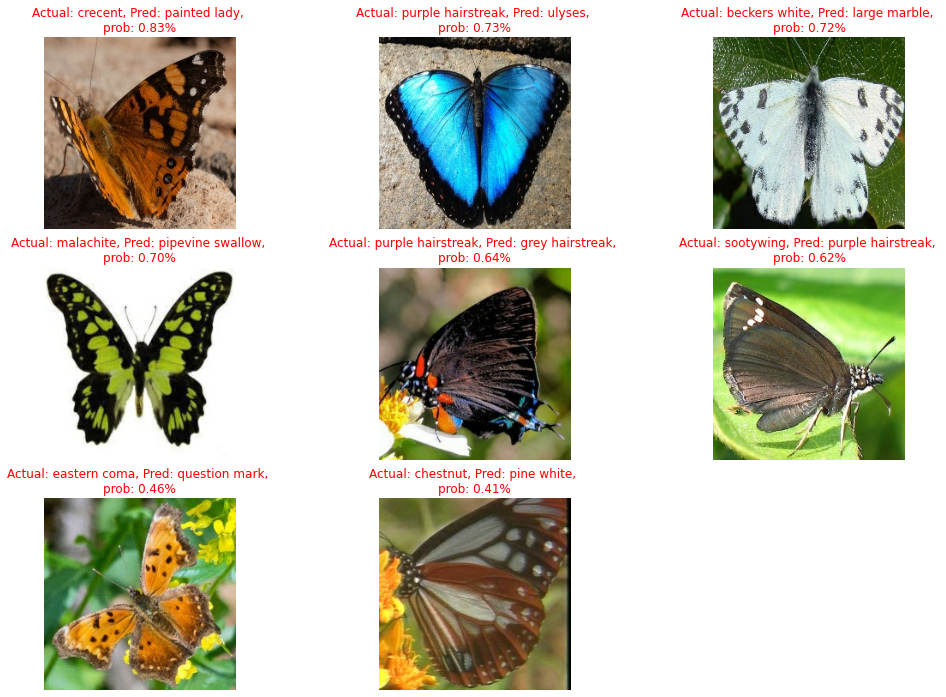

In [ ]:
# Plotting wrong predictions with insights
plt.figure(figsize=(17, 12))
for i in range(len(filepaths)):
  img = load_and_preprocess(filepaths[i])
  plt.subplot(3, 3, i+1)
  plt.axis(False)
  plt.imshow(img / 255.)
  plt.title(f"Actual: {true[i]}, Pred: {pred[i]}, \nprob: {prob[i]:.2f}%", color="red");